We are working on the Burger's Equation: <br>
$u_t + uu_x = \nu u_{xx}$ with $x \in [-1,1]$.<br> <br>
Provided are the Dirichlet boundary conditions $u(t,-1)=u(t,1)=0$ and noisy measurements $\{x^0, u^0\}$ of the black-box initial function $u(0,x)=-\sin(\pi x)$. <br>
The noise is chosen to be uniformly distributed in $[-0.25, 0.25].$ <br> <br>
We apply the backward Euler scheme to discretize over time: <br>
$u^{n}(x) = u^{n-1}(x) - \Delta t u^n \frac{d}{dx}u^n(x) + \Delta t \nu \frac{d^2}{dx^2}u^n(x)$ <br> <br>
In order to be able to put Gaussian Processes as priors on $u^{n-1}$ and on $u^n$, we have to relinquish the non-linear term and approximate it with $\mu^{n-1}$, which is the posterior mean of the $n-1$-th time step. We get: <br>
$u^n(x) = u^{n-1}(x) - \Delta t \mu^{n-1} \frac{d}{dx}u^n(x) + \Delta t \nu \frac{d^2}{dx^2}u^n(x)$. <br> <br>
Or:
$
u^{n-1}(x) = u^n(x) + \Delta t \mu^{n-1} \frac{d}{dx}u^n(x) - \Delta t \nu \frac{d^2}{dx^2}u^n(x) =: \mathcal{L}_x u^n(x)
$
<br> <br>
We can then assume: <br>
Prior: $u^n \sim \mathcal{GP}(0, k(x,x';\theta_n))$ <br> <br>
We obtain the Numerical Gaussian Process: <br>
$\begin{pmatrix}
u^n \\
u^{n-1} \end{pmatrix}
\sim
\mathcal{GP}\left(0,
\begin{pmatrix}
k_{u,u}^{n,n} & k_{u,u}^{n,n-1} \\
k_{u,u}^{n-1,n} & k_{u,u}^{n-1,n-1}
\end{pmatrix} \right)$, where $k_{u,u}^{n,n} = k$.
<br> 


#### Step 1: Simulate data

In [131]:
import time
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [132]:
n = 24
np.random.seed(int(time.time()))
noise = 0.5*np.random.rand(24) - 0.25
x0 = 2*np.random.rand(n) - 1 
u0 = -np.sin(2*np.pi*x0) + noise

xb = np.array([-1,1])
ub = np.array([0,0])

Plotting the function

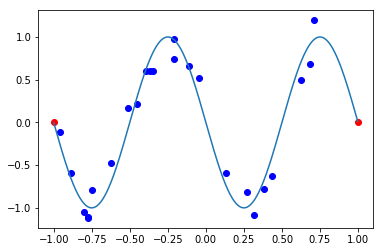

In [133]:
plt.plot(x0,u0,'bo')
plt.plot(xb,ub,'bo', color = 'red')
xplot = np.arange(-1,1,0.002)
uplot = -np.sin(2*np.pi*xplot)
plt.plot(xplot,uplot)

#### Step 2: evaluate kernels and covariance matrix

Declare symbols

In [134]:
x, xp, sig0, sig = sp.symbols('x, xp, sig0, sig')

We choose a non-stationary prior, since Burger's equation can develop discontinuities: <br>
$ k_{u,u}^{n,n} = k(x, x'; \theta) = \frac{2}{\pi}\sin^{-1}\left( 
\frac{2(\sigma_0^2 + \sigma^2xx')}{\sqrt{(1+2(\sigma_0^2 + \sigma^2x^2))(1+2(\sigma_0^2 + \sigma^2x'^2))}} \right)$    

In [135]:
k_sym = 2/sp.pi*sp.asin(2*(sig0**2 + sig**2*x*xp)/sp.sqrt((1+2*(sig0**2+sig**2*x**2))*(1+2*(sig0**2+sig**2*xp**2))))
k_fn = sp.lambdify((x, xp, sig0, sig), k_sym, "numpy")
def k(x, sig0, sig):
    m = np.zeros((x.size, x.size))
    for i in range(x.size):
        for j in range(x.size):
            m[i,j] = k_fn(x[i], x[j], sig0, sig)
    return m

Choosing parameters

In [136]:
mu = np.mean(u0)
dt = 0.01
nu = dt/np.pi

$k_{u,u}^{n,n-1} = \mathcal{L}_{x'}k = k + \Delta t \mu^{n-1}(x')\frac{d}{dx'}k - \nu \Delta t \frac{d^2}{dx'^2}k$

In [137]:
knn0_sym = k_sym + dt*mu*sp.diff(k_sym, xp) - nu*dt*sp.diff(k_sym, xp, xp)
knn0_fn = sp.lambdify((x, xp, sig0, sig), knn0_sym, "numpy")
def knn0(xb, x, sig0, sig):
    m = np.zeros((xb.size, x.size))
    for i in range(xb.size):
        for j in range(x.size):
            m[i,j] = knn0_fn(xb[i], x[j], sig0, sig)
    return m

$k_{u,u}^{n-1,n} = \mathcal{L}_{x}k = k + \Delta t \mu^{n-1}(x)\frac{d}{dx}k - \nu \Delta t \frac{d^2}{dx^2}k$

In [138]:
def kn0n(xb, x, sig0, sig):
    return knn0(xb, x, sig0, sig).T

Calculating the kernel of $u^{n-1}$: <br>
$k_{u,u}^{n-1,n-1} = \mathcal{L}_x \mathcal{L}_{x'} k = \mathcal{L}_x k_{u,u}^{n,n-1} \\ = k_{u,u}^{n,n-1} + \Delta t \mu^{n-1}(x)\frac{d}{dx}k_{u,u}^{n,n-1} - \nu \Delta t \frac{d^2}{dx^2}k_{u,u}^{n,n-1} \\ = k + \Delta t \mu^{n-1}(x')\frac{d}{dx'}k - \nu \Delta t \frac{d^2}{dx'^2}k + \Delta t \mu^{n-1}(x)\frac{d}{dx}k + \Delta t^2 \mu^{n-1}(x)\mu^{n-1}(x')\frac{d}{dx}\frac{d}{dx'}k - \nu \Delta t^2 \mu^{n-1}(x)\frac{d}{dx}\frac{d^2}{dx'^2}k - \nu \Delta t \frac{d^2}{dx^2}k - \nu \Delta t^2 \mu^{n-1}(x')\frac{d^2}{dx^2}\frac{d}{dx'}k + \nu^2\Delta t^2 \frac{d^2}{dx^2} \frac{d^2}{dx'^2}k$

In [139]:
kn0n0_sym = knn0_sym + dt*mu*sp.diff(knn0_sym, x) - mu*dt*sp.diff(knn0_sym, x, x)
kn0n0_fn = sp.lambdify((x, xp, sig0, sig), kn0n0_sym, "numpy")
def kn0n0(x, sig0, sig):
    m = np.zeros((x.size, x.size))
    for i in range(x.size):
        for j in range(x.size):
            m[i,j] = kn0n0_fn(x[i], x[j], sig0, sig)
    return m

#### Step 3: create covariance matrix and NLML

```
params = [sig0, sig]
```

In [140]:
def nlml(params, xb, x0, ub, u0, s):
    params = np.exp(params)
    K = np.block([
        [
            k(xb, params[0], params[1]) + s*np.identity(xb.size),
            knn0(xb, x0, params[0], params[1])
        ],
        [
            kn0n(xb, x0, params[0], params[1]),
            kn0n0(x0, params[0], params[1]) + s*np.identity(x0.size)
        ]
    ])
    y = np.concatenate((ub,u0))
    val = 0.5*(np.log(abs(np.linalg.det(K))) + np.mat(y) * np.linalg.inv(K) * np.mat(y).T)
    return val.item(0)

In [141]:
nlml((1,1), xb, x0, ub, u0, 1e-8)

5949290.832508889

In [142]:
nlml_wp = lambda params: nlml(params, xb, x0, ub, u0, 1e-8)
res = minimize(nlml_wp, np.random.rand(2), method="Nelder-Mead", options={'maxiter' : 5000, 'fatol' : 0.001})
res

 final_simplex: (array([[1.39185121, 1.39541777],
       [1.39185121, 1.39541777],
       [1.39185121, 1.39541777]]), array([-3.23761254e+15, -3.23761254e+15, -3.23761254e+15]))
           fun: -3237612538384236.5
       message: 'Optimization terminated successfully.'
          nfev: 338
           nit: 150
        status: 0
       success: True
             x: array([1.39185121, 1.39541777])

Predicting $u_n(x_{\ast}^n)$ at a test point $x_{\ast}^n$: <br>
$u^n(x_{\ast}^n) \vert \begin{pmatrix} u_b^n \\ u^{n-1} \end{pmatrix} \sim \mathcal{N} \left( q^T K^{-1} \begin{pmatrix} u_b^n \\ u^{n-1} \end{pmatrix} , k_{u,u}^{n,n}(x_{\ast}^n, x_{\ast}^n) - q^T K^{-1}q \right)$, where <br>
$ q^T := \begin{pmatrix} k_{u,b}^{n,n}(x_{\ast}^n, x_b^n) & k_{u,u}^{n, n-1}(x_{\ast}^n, x^{n-1}) \end{pmatrix} $ <br>
So the expected value is: <br>
$u^n(x_{\ast}^n) = q^T K^{-1} \begin{pmatrix} u_b^n \\ u^{n-1} \end{pmatrix}$.

In [149]:
sig0 = np.exp(res.x[0])
sig = np.exp(res.x[1])
s = 1e-8
xstar = 0.8                # As an example

K = np.block([
    [
        k(xb, sig0, sig) + s*np.identity(xb.size),
        knn0(xb, x0, sig0, sig)
    ],
    [
        kn0n(xb, x0, sig0, sig),
        kn0n0(x0, sig0, sig) + s*np.identity(x0.size)
    ]
])

q = np.zeros(xb.size + x0.size)

for i in range(xb.size):
    q[i] = k_fn(xb[i], xstar, sig0, sig)
    
for j in range(x0.size):
    q[xb.size + j] = knn0_fn(x0[j], xstar, sig0, sig)
    
y = np.concatenate([ub, u0])

print((q.T).dot(np.linalg.inv(K)).dot(y))


4.022289251796972
192914482.55315757


In [ ]:
#def minimize_restarts(xb, x0, ub, u0, n = 5):
#    nlml_wp = lambda params: nlml(params, xb, x0, ub, u0, 1e-8)
#    all_results = []
#    for it in range(0,n):
#        all_results.append(minimize(nlml_wp, np.random.rand(2), method="Nelder-Mead", options={'maxiter' : 5000, 'fatol' : 0.001}))
#    filtered_results = [m for m in all_results if 0 == m.status]
#    return min(filtered_results, key = lambda x: x.fun)

In [ ]:
#m = minimize_restarts(xb, x0, ub, u0)
#m